# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Variational autoencoder



# Theoretical recalls
<hr style="border:2px solid black"> </hr>

## What is a variation autoencoder?


- **General knowledge** Autoencoders (AEs) are used for classification, clustering and feature compression. AEs, can be trained without supervision. Both AEs and VAEs is primarily used for unsupervised learning of hidden representations.
- **What makes them different?** VAEs, comparing to AE, compress probabilities instead of features.
- **An intuitive view** AEs answer the question “how can we generalise data?” VAEs answer the question “how strong is a connection between two events? should we distribute error between the two events or they are completely independent?”.
- **Is variational Autoencoder a generative model?** VAE's are class of deep generative networks which has the encoder <u>(inference)</u> and decoder <u>(generative)</u> parts similar to the classic auto-encoder.



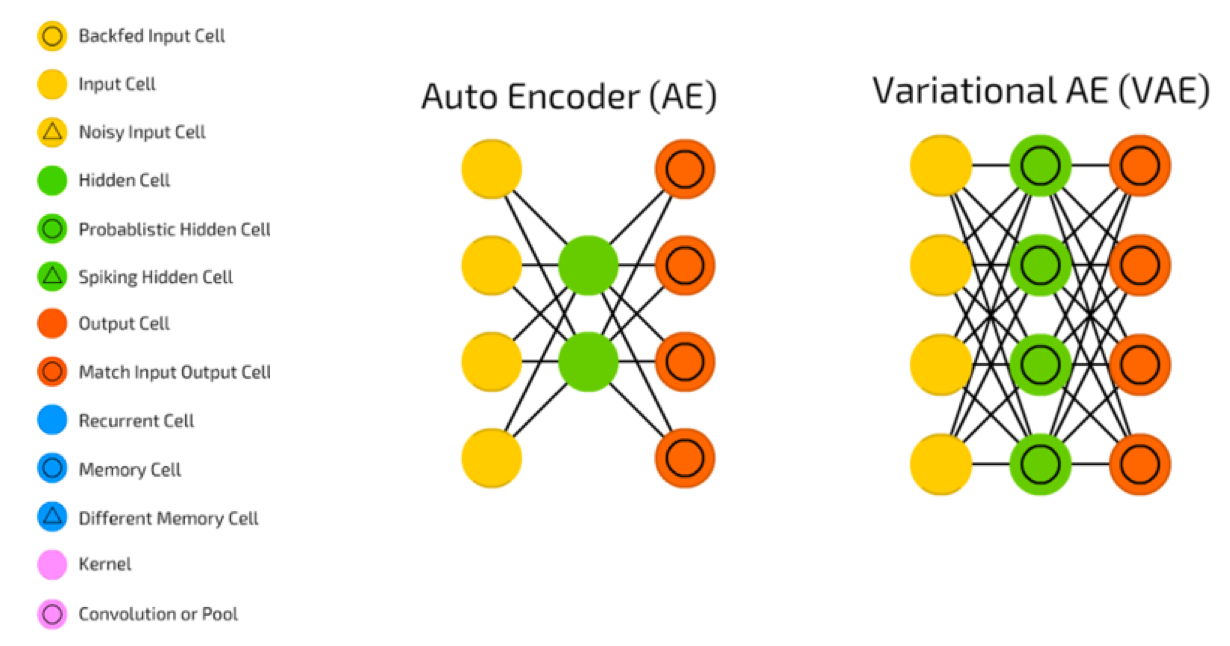

## Encoder vs. PCA


- Training an autoencoder with one dense encoder layer and one dense decoder layer and linear activation is essentially equivalent to performing PCA.
- While PCA attempts to find a low dimensional hyperplane which captures the highest variation in the data, autoencoder achieves it by learning non-linear manifolds in the data. 
- An autoencoder can learn non-linear transformations, unlike PCA, with a non-linear activation function and multiple layers.
- An autoencoder doesn’t have to learn dense (affine) layers; it can use convolutional layers to learn too, which could be better for video, image and series data.
- It may be more efficient, in terms of model parameters, to learn several layers with an autoencoder rather than learn one huge transformation with PCA.
- An autoencoder gives a representation as the output of each layer, and maybe having multiple representations of different dimensions is useful.
- An autoencoder could let you make use of pre trained layers from another model, to apply transfer learning to prime the encoder/decoder.


- **These consideration can be extended to VAEs as well.**



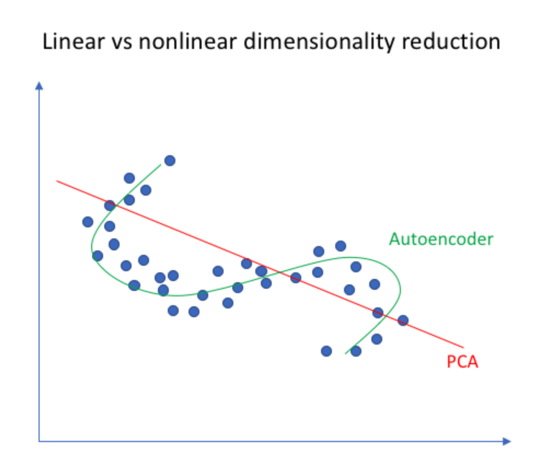

# Import modules
<hr style="border:2px solid black"> </hr>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, InputLayer, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

In [2]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [3]:
tf.compat.v1.disable_eager_execution()

# Import the dataset
<hr style="border:2px solid black"> </hr>


- The MNIST data set has over **60k** images.
- You can reduced the size down to 10k to speed up the training. This may nto be ideal from an accuracy point of view.



In [4]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255
x_test = np.expand_dims(x_test, axis=-1) / 255

In [5]:
print(x_train.shape)
print(x_train.shape[1:])

(60000, 28, 28, 1)
(28, 28, 1)


In [6]:
img_rows, img_cols, img_chns = x_train.shape[1:]

In [7]:
original_dim = img_rows * img_cols
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 1.0

In [8]:
original_dim

784

# KL Divergence
<hr style="border:2px solid black"> </hr>


- Intuitively, maximizing the negative KL divergence term encourages approximate posterior densities that place its mass on configurations of the latent variables which are closest to the prior. Effectively, this regularises the complexity of latent space



In [9]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

# Loss function
<hr style="border:2px solid black"> </hr>


- We are going to use the **negative log lokelihod (Bernouilli)**
- Please note that the negative log likelihood of a Bernoulli is equivalent to the binary cross-entropy loss.
- This will not be the loss we ultimately minimize, but will constitute the data-fitting term of our final loss.



In [10]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


- There is another way of doing the same. The only difference is that it is not calling `K.binary_crossentropy` directly.



In [11]:
def nll_equivalent(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    lh = K.tf.distributions.Bernoulli(probs=y_pred)

    return - K.sum(lh.log_prob(y_true), axis=-1)

# Modelling
<hr style="border:2px solid black"> </hr>

In [ ]:

- 



In [12]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x_pred = decoder(z)

In [13]:
vae = Model(inputs=[x, eps], outputs=x_pred, name='vae')
vae.compile(optimizer='rmsprop', loss=nll)

In [14]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            514         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense[0][0]                      
________________________________________________________________________________________________

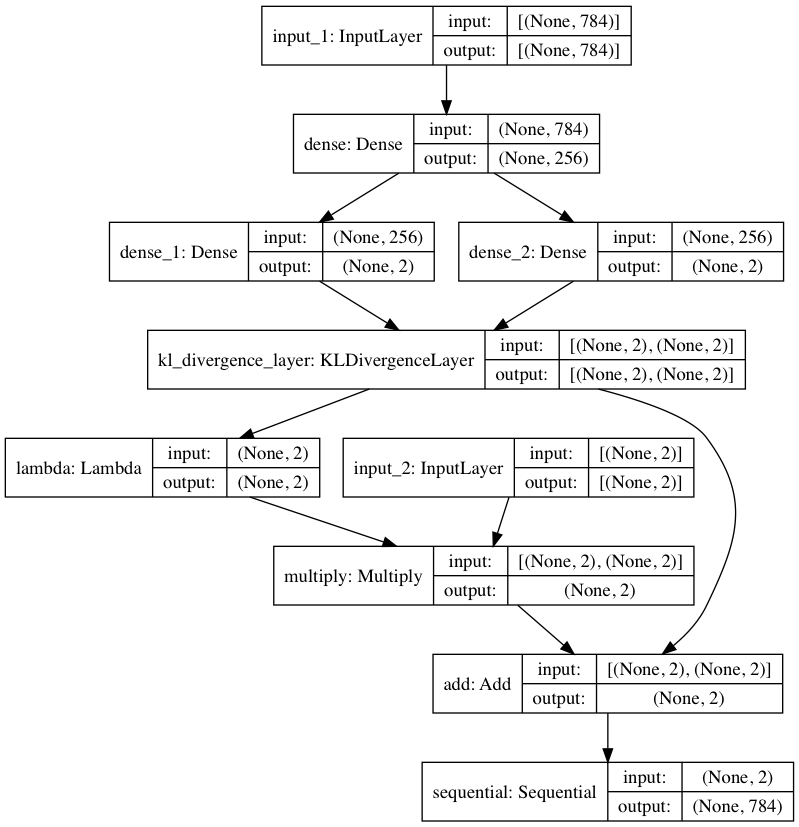

In [15]:
plot_model(vae, show_shapes = True)

In [16]:
# Reading again the dataset for the final training
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

In [17]:
hist = vae.fit(
    x_train,
    x_train,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 63us/sample - loss: 190.1607 - val_loss: 172.5522
Epoch 2/50
60000/60000 [==============================] - 3s 56us/sample - loss: 170.0677 - val_loss: 168.2146
Epoch 3/50
60000/60000 [==============================] - 3s 56us/sample - loss: 166.7563 - val_loss: 165.6103
Epoch 4/50
60000/60000 [==============================] - 3s 56us/sample - loss: 164.6897 - val_loss: 164.1500
Epoch 5/50
60000/60000 [==============================] - 3s 55us/sample - loss: 163.1897 - val_loss: 162.8088
Epoch 6/50
60000/60000 [==============================] - 3s 55us/sample - loss: 161.9742 - val_loss: 161.5412
Epoch 7/50
60000/60000 [==============================] - 3s 55us/sample - loss: 160.7925 - val_loss: 160.3970
Epoch 8/50
60000/60000 [==============================] - 3s 55us/sample - loss: 159.7152 - val_loss: 159.7226
Epoch 9/50
60000/60000 [==============================] - 3s 5

# Model diagnostic
<hr style="border:2px solid black"> </hr>


- Essentially we are checking if the model **overfitted** the trainin data.
- From the graph we can see that probably the model would have benefitted from training a little bit longer.



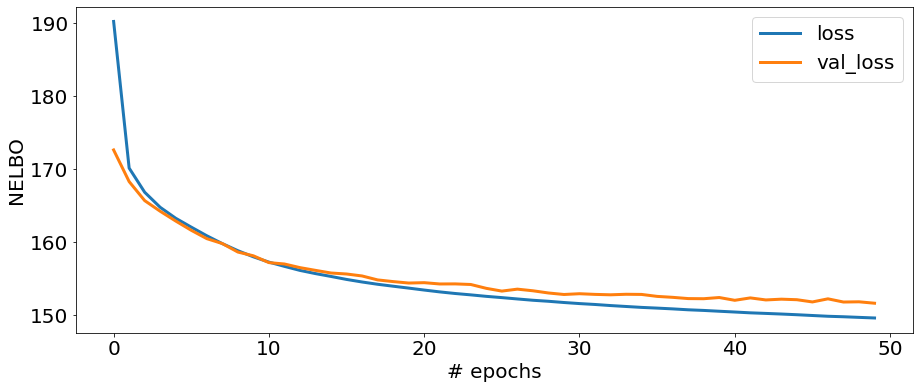

In [18]:
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 20

fig, ax = plt.subplots()
hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax, lw = 3)
ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')
plt.show()

# Post-processing
<hr style="border:2px solid black"> </hr>

## Display a 2D manifold of the images

In [19]:
n = 15  # figure with 15x15 images
quantile_min = 0.01
quantile_max = 0.99

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(quantile_min, quantile_max, n))
z2 = norm.ppf(np.linspace(quantile_max, quantile_min, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

In [20]:
x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, img_rows, img_cols)

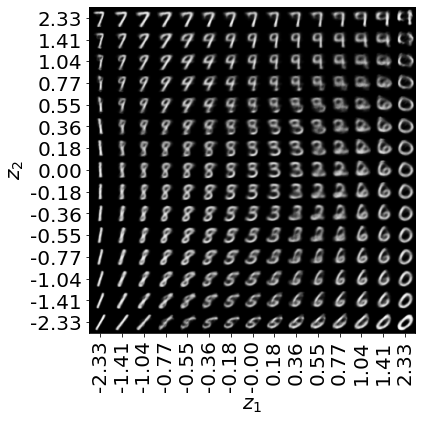

In [27]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')

ax.set_xticks(np.arange(0, n*img_rows, img_rows) + .5 * img_rows)
ax.set_xticklabels(map('{:.2f}'.format, z1), rotation=90)

ax.set_yticks(np.arange(0, n*img_cols, img_cols) + .5 * img_cols)
ax.set_yticklabels(map('{:.2f}'.format, z2))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
plt.show()

## Model evaluation

In [22]:
# deterministic test time encoder
test_encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = test_encoder.predict(x_test, batch_size=batch_size)

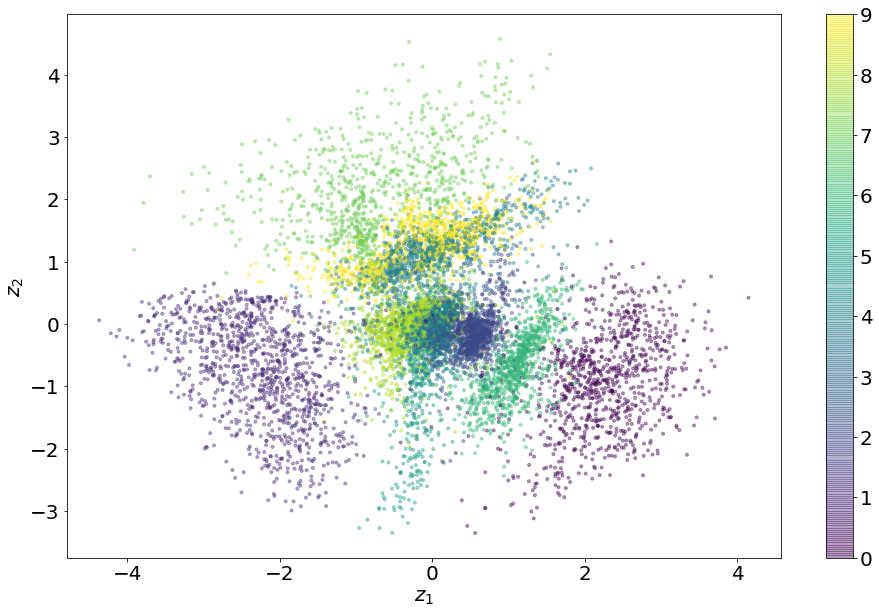

In [23]:
fig, ax = plt.subplots(figsize=(16, 10))

cbar = ax.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
                   alpha=.4, s=3**2, cmap='viridis')
fig.colorbar(cbar, ax=ax)

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
plt.show()

# Conclusions
<hr style="border:2px solid black"> </hr>


- Implemented the decoder and encoder using the Sequential and functional Model API respectively.
- Augmented the final loss with the KL divergence term by writing an auxiliary custom layer.
- Worked with the log variance for numerical stability, and used a Lambda layer to transform it to the standard deviation when necessary.
- Explicitly made the noise an Input layer, and implemented the reparameterization trick using Merge layers.
- Fixed the noise input to a stochastic tensor, so random samples are generated within the computation graph.



# References
<hr style="border:2px solid black"> </hr>


- https://github.com/kvfrans/variational-autoencoder
- https://keras.io/examples/generative/vae/
- https://towardsdatascience.com/the-mostly-complete-chart-of-neural-networks-explained-3fb6f2367464 
- https://medium.com/analytics-vidhya/generative-modelling-using-variational-autoencoders-vae-and-beta-vaes-81a56ef0bc9f
- https://medium.com/@venkatakrishna.jonnalagadda/sparse-stacked-and-variational-autoencoder-efe5bfe73b64 
- https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/

